as a symbol:

- I should know how to load and save .pkl file
- I should code a function that shows me each time the folder structure .pkl so as not to get lost
- I should know how to navigate the pkl file
- I should code verification functions about my dataset to see if everything is ok

                                Helper functions
                                

In [22]:

import pickle
import os
import rasterio
from pyproj import Transformer
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from rasterio.transform import rowcol

save_path = r"C:\Users\adamh\Desktop\Satelite_images\Toulouse_data.pkl"

city_path = r"C:\Users\adamh\Desktop\Satelite_images\Satellite_Images\Clermont-Ferrand\2021"
def show(data):
    """
    Inspect the structure of the 'data' dictionary.
    For each year, it prints the available keys, types, and shapes if applicable.
    """
    print("🔎 Exploring data structure\n" + "-"*60)
    for year_key, year_data in data.items():
        print(f"{year_key}")
        
        if not isinstance(year_data, dict):
            print(f"  ⚠️ Expected dict, got {type(year_data)}\n")
            continue
        
        # Loop through subkeys (like imgs_array, iris_index, etc.)
        for key, value in year_data.items():
            info = f"  ├─ {key:<25} → "
            
            # Describe arrays
            if isinstance(value, (list, tuple)):
                info += f"list[{len(value)}]"
            elif isinstance(value, dict):
                info += f"dict[{len(value)}]"
            elif hasattr(value, "shape"):
                info += f"array shape={value.shape}, dtype={getattr(value, 'dtype', 'N/A')}"
            else:
                info += str(type(value))
            
            print(info)
        
        print("-"*60)

def save(data, save_path):
    with open(save_path, "wb") as f:
       pickle.dump(data, f)
    print(f"✅ Data saved successfully at: {save_path}")

def load(save_path):
    with open(save_path, "rb") as f:
       data = pickle.load(f)
    print("✅ Data loaded successfully!")

    return data
    
def read_band(file):
    """Lit une bande Landsat et nettoie les valeurs aberrantes."""
    with rasterio.open(file) as src:
        band = src.read(1).astype(float)
        # Supprime les valeurs saturées ou nulles
        band[(band <= 0) | (band >= 60000)] = 0
        return band
    
def get_array_img(path, date):
    B1 = ""
    B2 = ""
    B3 = ""
    B4 = ""
    B5 = ""
    B6 = ""
    for dirpath, _, filenames in os.walk(path):
        for f in filenames:
            if f.lower().endswith("b1.tif"):
                B1 = os.path.join(dirpath, f)
            if f.lower().endswith("b2.tif"):
                B2 = os.path.join(dirpath, f)
            if f.lower().endswith("b3.tif"):
                B3 = os.path.join(dirpath, f)
            if f.lower().endswith("b4.tif"):
                B4 = os.path.join(dirpath, f)
            if f.lower().endswith("b5.tif"):
                B5 = os.path.join(dirpath, f)
            if f.lower().endswith("b6.tif"):
                B6 = os.path.join(dirpath, f)
    

    if date >= 2013:
        red = read_band(B6) 
        green = read_band(B5) 
        blue = read_band(B4)

        red = red / red.max()
        green = green / green.max()
        blue = blue / blue.max()
    
    else:
        red = read_band(B5)
        green = read_band(B4)
        blue = read_band(B3)

    
    rgb = np.dstack((red, green, blue))
    p2, p98 = np.nanpercentile(rgb, (2, 98))
    rgb_norm = np.clip((rgb - p2) / (p98 - p2), 0, 1)
    rgb_8bit = (rgb_norm * 255).astype(np.uint8)

    return rgb_8bit

def return_tif_files(dir):
    for dirpath, _, filenames in os.walk(dir):
        for f in filenames:
            if f.lower().endswith(".tif"):
                path = os.path.join(dirpath, f)
                try:
                    with rasterio.open(path) as src:
                        if src.crs is not None and src.transform is not None:
                            return path
                
                except rasterio.errors.RasterioIOError:
                    continue

def get_grid_coordinates(path, format = "lat_lon"): #this file ends with .Tif

    with rasterio.open(path) as src:
        transform = src.transform
        crs = src.crs
        width, height = src.width, src.height

    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(transform, rows, cols, offset='center')

    xs = np.array(xs).reshape(height, width)
    ys = np.array(ys).reshape(height, width)

    if format != "lat_lon":
        return xs, ys
    
    transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
    lons, lats = transformer.transform(xs, ys)

    return lons, lats

def world_to_pixel(x, y, transform):
    """Convert geospatial coords (x,y) to pixel indices (row,col)."""
    col, row = ~transform * (x, y)
    return int(round(row)), int(round(col))

def pixel_to_world(col, row, transform):
    """Convert pixel indices (col,row) to geospatial coordinates (x,y)."""
    x, y = transform * (col, row)
    return x, y

def parse_bounding_box(bbox_str1, bbox_str2):
    """
    Parse bounding box coordinates from Klokantech formats and return decimal (lat/lon) values.
    
    Parameters:
        bbox_str1 (str): Format like "$$dE0030300$$eE0031000$$fN0454900$$gN0454500"
        bbox_str2 (str): Format like "$$c(E 3°03'00\"--E 3°10'00\"/N 45°49'00\"--N 45°45'00\")"
    
    Returns:
        dict: {
            "lon_min": float,
            "lon_max": float,
            "lat_min": float,
            "lat_max": float
        }
    """
    
    def dms_to_dd(deg, min_, sec=0):
        """Convert degrees/minutes/seconds to decimal degrees."""
        return deg + min_/60 + sec/3600

    # --- Try parsing numeric pattern first (bbox_str1)
    match = re.findall(r'([EWNS])(\d{3,4})(\d{2})(\d{2})', bbox_str1)
    if match:
        coords = {d: dms_to_dd(int(a), int(b), int(c)) for d, a, b, c in match}
        lon_min = coords.get('E', coords.get('W', 0))
        lon_max = lon_min  # default if only one
        lat_min = coords.get('S', coords.get('N', 0))
        lat_max = lat_min
        # heuristic: first E is west, second is east; first N is north, second is south
        E_vals = [dms_to_dd(int(a), int(b), int(c)) for d, a, b, c in match if d in ['E', 'W']]
        N_vals = [dms_to_dd(int(a), int(b), int(c)) for d, a, b, c in match if d in ['N', 'S']]
        if len(E_vals) == 2: lon_min, lon_max = sorted(E_vals)
        if len(N_vals) == 2: lat_min, lat_max = sorted(N_vals)
        return {
            "lat_min": lat_min,
            "lat_max": lat_max,
            "lon_min": lon_min,
            "lon_max": lon_max
        }

    # --- Otherwise, parse human-readable pattern (bbox_str2)
    # Example: $$c(E 3°03'00"--E 3°10'00"/N 45°49'00"--N 45°45'00")"
    matches = re.findall(r'([EWNS])\s?(\d+)°(\d+)', bbox_str2)
    if len(matches) >= 4:
        conv = []
        for hemi, deg, minute in matches:
            val = dms_to_dd(int(deg), int(minute))
            if hemi in ['W', 'S']:
                val = -val
            conv.append((hemi, val))
        # Sort by direction
        lon_vals = [v for h, v in conv if h in ['E', 'W']]
        lat_vals = [v for h, v in conv if h in ['N', 'S']]
        lon_min, lon_max = sorted(lon_vals)
        lat_min, lat_max = sorted(lat_vals)
        return {
            "lat_min": lat_min,
            "lat_max": lat_max,
            "lon_min": lon_min,
            "lon_max": lon_max
        }

    raise ValueError("Unable to parse bounding box from provided strings.")

def get_patch_from_bbox(bbox, city_path):
    """
    Convert a lat/lon bounding box to pixel coordinates using the raster CRS.
    Returns (i, j, patch_size_x, patch_size_y).
    """
    ref_path = os.path.join(city_path, "B4.tif")
    if not os.path.exists(ref_path):
        raise FileNotFoundError(f"❌ Missing {ref_path}")

    with rasterio.open(ref_path) as src:
        transform = src.transform
        crs = src.crs

        # Transformer: from WGS84 (EPSG:4326) → raster CRS
        transformer = Transformer.from_crs("EPSG:4326", crs, always_xy=True)

        # Convert lon/lat to raster coordinate system
        x_min, y_min = transformer.transform(bbox["lon_min"], bbox["lat_min"])
        x_max, y_max = transformer.transform(bbox["lon_max"], bbox["lat_max"])

        # Convert projected coordinates → pixel indices
        row_min, col_min = rowcol(transform, x_min, y_max)  # top-left
        row_max, col_max = rowcol(transform, x_max, y_min)  # bottom-right

        i = min(col_min, col_max)
        j = min(row_min, row_max)
        patch_size_x = abs(col_max - col_min)
        patch_size_y = abs(row_max - row_min)

    return {
        "i": int(i),
        "j": int(j),
        "patch_size_x": int(patch_size_x),
        "patch_size_y": int(patch_size_y)
    }
"""
Lyon
patch_size_x = 1000, patch_size_y = 800
i, j = 4400, 5000

Paris
patch_size_x = 1600, patch_size_y = 1600
i, j = 3000, 3000

Toulouse
patch_size_x = 1000, patch_size_y = 600
i, j = 1800, 2600

Bordeaux
patch_size_x = 800, patch_size_y = 800
i, j = 2600, 4100
"""
               

patch_size_x = 1000
patch_size_y = 600
i = 1800
j = 2600

                                 Experimenting

In [ ]:
# ==============================================================
# 🗺️ City Bounding Boxes + Pixel Patch Extraction (2021 example)
# ==============================================================
# --- Clermont ---

Clermont_bbox_str1 = "$$dE0030300$$eE0031000$$fN0454900$$gN0454500"
Clermont_bbox_str2 = "$$c(E 3°03'00\"--E 3°10'00\"/N 45°49'00\"--N 45°45'00\")"
Clermont_city_path = r"C:\Users\adamh\Desktop\Satelite_images\Satellite_Images\Clermont-Ferrand\2021"

bbox_Clermont = parse_bounding_box(Clermont_bbox_str1, Clermont_bbox_str2)
results = get_patch_from_bbox(bbox_Clermont, Clermont_city_path)

# --- Limoges ---
Limoges_bbox_str1 = "$$dE0010846$$eE0011903$$fN0455541$$gN0454719"
Limoges_bbox_str2 = "$$c(E 1°08'46\"--E 1°19'03\"/N 45°55'41\"--N 45°47'19\")"
Limoges_city_path = r"C:\Users\adamh\Desktop\Satelite_images\Satellite_Images\Limoges\2021"

bbox_Limoges = parse_bounding_box(Limoges_bbox_str1, Limoges_bbox_str2)
Limoges_results = get_patch_from_bbox(bbox_Limoges, Limoges_city_path)


# --- Rennes ---
Rennes_bbox_str1 = "$$dW0014509$$eW0013727$$fN0480917$$gN0480436"
Rennes_bbox_str2 = "$$c(W 1°45'09\"--W 1°37'27\"/N 48°09'17\"--N 48°04'36\")"
Rennes_city_path = r"C:\Users\adamh\Desktop\Satelite_images\Satellite_Images\Rennes\2021"

bbox_Rennes = parse_bounding_box(Rennes_bbox_str1, Rennes_bbox_str2)
Rennes_results = get_patch_from_bbox(bbox_Rennes, Rennes_city_path)


# --- Orléans ---
Orleans_bbox_str1 = "$$dE0015200$$eE0015600$$fN0475600$$gN0474800"
Orleans_bbox_str2 = "$$c(E 1°52'00\"--E 1°56'00\"/N 47°56'00\"--N 47°48'00\")"
Orleans_city_path = r"C:\Users\adamh\Desktop\Satelite_images\Satellite_Images\Orleans\2021"

bbox_Orleans = parse_bounding_box(Orleans_bbox_str1, Orleans_bbox_str2)
Orleans_results = get_patch_from_bbox(bbox_Orleans, Orleans_city_path)


# --- Dijon ---
Dijon_bbox_str1 = "$$dE0045744$$eE0050607$$fN0472238$$gN0471710"
Dijon_bbox_str2 = "$$c(E 4°57'44\"--E 5°06'07\"/N 47°22'38\"--N 47°17'10\")"
Dijon_city_path = r"C:\Users\adamh\Desktop\Satelite_images\Satellite_Images\Dijon\2021"

bbox_Dijon = parse_bounding_box(Dijon_bbox_str1, Dijon_bbox_str2)
Dijon_results = get_patch_from_bbox(bbox_Dijon, Dijon_city_path)


# --- Poitiers ---
Poitiers_bbox_str1 = "$$dE0001727$$eE0002706$$fN0463737$$gN0463232"
Poitiers_bbox_str2 = "$$c(E 0°17'27\"--E 0°27'06\"/N 46°37'37\"--N 46°32'32\")"
Poitiers_city_path = r"C:\Users\adamh\Desktop\Satelite_images\Satellite_Images\Poitiers\2021"

bbox_Poitiers = parse_bounding_box(Poitiers_bbox_str1, Poitiers_bbox_str2)
Poitiers_results = get_patch_from_bbox(bbox_Poitiers, Poitiers_city_path)


# --- Rouen ---
Rouen_bbox_str1 = "$$dE0010148$$eE0010907$$fN0492754$$gN0492501"
Rouen_bbox_str2 = "$$c(E 1°01'48\"--E 1°09'07\"/N 49°27'54\"--N 49°25'01\")"
Rouen_city_path = r"C:\Users\adamh\Desktop\Satelite_images\Satellite_Images\Rouen\2021"

bbox_Rouen = parse_bounding_box(Rouen_bbox_str1, Rouen_bbox_str2)
Rouen_results = get_patch_from_bbox(bbox_Rouen, Rouen_city_path)


# --- Display all ---
print("🧭 Patch extraction results:")
print("Limoges:", Limoges_results)
print("Rennes:", Rennes_results)
print("Orléans:", Orleans_results)
print("Dijon:", Dijon_results)
print("Poitiers:", Poitiers_results)
print("Rouen:", Rouen_results)





    

{'i': 536, 'j': 4727, 'patch_size_x': 302, 'patch_size_y': 247}


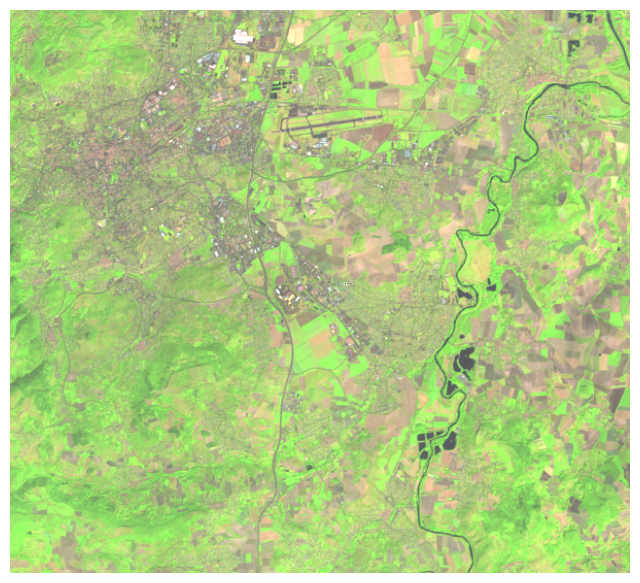

In [31]:
img = get_array_img(city_path, 2021)

j = results["i"]
i = results["j"]
patch_size_y = results["patch_size_x"] + 300
patch_size_x = results["patch_size_y"] + 300


rgb_patch = img[i:i+patch_size_x, j:j+patch_size_y,:]

plt.figure(figsize=(8, 8))
plt.imshow(rgb_patch)
plt.title("")
plt.axis('off')
plt.show()

                                  Skip

In [13]:

img = get_array_img(city_path, 2021)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title("")
plt.axis('off')
plt.show()

In [12]:
"""
Lyon
patch_size_x = 1000, patch_size_y = 800
i, j = 4400, 5000

Paris
patch_size_x = 1600, patch_size_y = 1600
i, j = 3000, 3000

Toulouse
patch_size_x = 1000, patch_size_y = 600
i, j = 1800, 2600

Bordeaux
patch_size_x = 800, patch_size_y = 800
i, j = 2600, 4100
"""

'\nLyon\npatch_size_x = 1000, patch_size_y = 800\ni, j = 4400, 5000\n\nParis\npatch_size_x = 1600, patch_size_y = 1600\ni, j = 3000, 3000\n\nToulouse\npatch_size_x = 1000, patch_size_y = 600\ni, j = 1800, 2600\n\nBordeaux\npatch_size_x = 800, patch_size_y = 800\ni, j = 2600, 4100\n'

In [11]:
patch_size_x = 1000
patch_size_y = 1500
i = 2200
j = 2200


rgb_patch = img[i:i+patch_size_x, j:j+patch_size_y,:]

plt.figure(figsize=(8, 8))
plt.imshow(rgb_patch)
plt.title("")
plt.axis('off')
plt.show()

In [ ]:
path2021 = r"C:\Users\adamh\Desktop\Satelite_images\Satellite_Images\Paris\2021"
path2020 = r"C:\Users\adamh\Desktop\Satelite_images\Satellite_Images\Paris\2020"
path2019 = r"C:\Users\adamh\Desktop\Satelite_images\Satellite_Images\Paris\2019"
img2021 = get_array_img(path2021, 2021)
img2020 = get_array_img(path2020, 2020)
img2019 = get_array_img(path2019, 2019)

In [15]:
plt.figure(figsize=(8, 8))
plt.imshow(img2021)
plt.title("")
plt.axis('off')
plt.show()

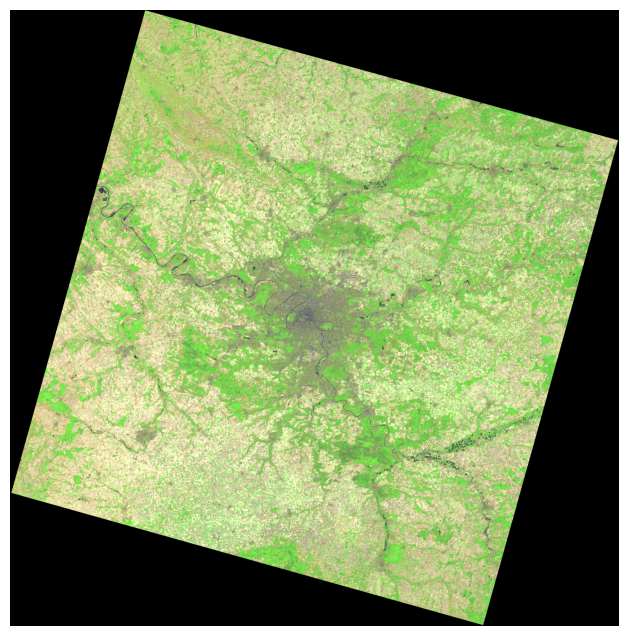

In [16]:
plt.figure(figsize=(8, 8))
plt.imshow(img2020)
plt.title("")
plt.axis('off')
plt.show()

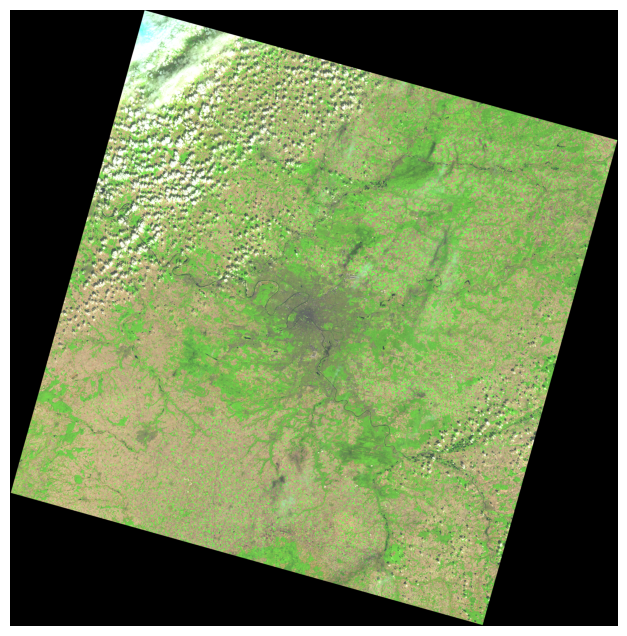

In [17]:
plt.figure(figsize=(8, 8))
plt.imshow(img2019)
plt.title("")
plt.axis('off')
plt.show()

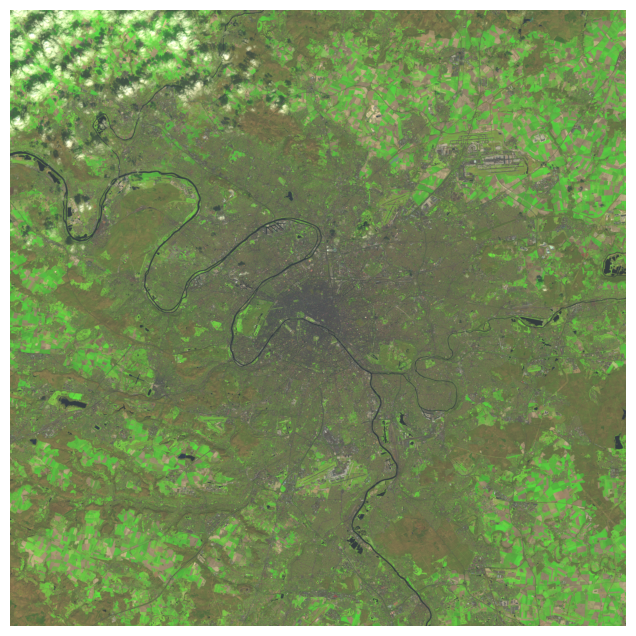

In [18]:
patch_size_x = 2000
patch_size_y = 2000
i = 3000
j = 3000
rgb_patch = img2021[i:i+patch_size_x, j:j+patch_size_y,:]

plt.figure(figsize=(8, 8))
plt.imshow(rgb_patch)
plt.title("")
plt.axis('off')
plt.show()

In [19]:
patch_size = 128
i = 4500
j = 4000
rgb_patch = img2020[i:i+patch_size, j:j+patch_size,:]

plt.figure(figsize=(8, 8))
plt.imshow(rgb_patch)
plt.title("")
plt.axis('off')
plt.show()

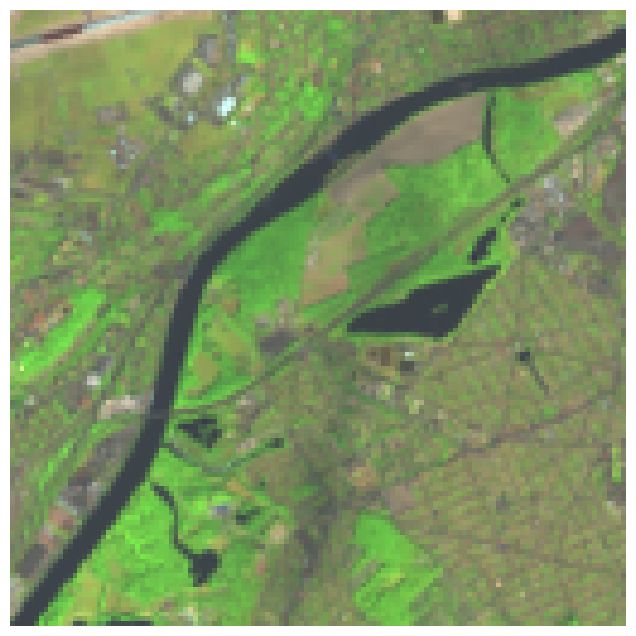

In [20]:
patch_size = 128
i = 4500
j = 4000
rgb_patch = img2019[i:i+patch_size, j:j+patch_size,:]

plt.figure(figsize=(8, 8))
plt.imshow(rgb_patch)
plt.title("")
plt.axis('off')
plt.show()

                                 get the same patch

In [48]:
# function such that I have the coordinates of the top_left pixels and it needs to give me the pixel
path_tif_file_2021 = return_tif_files(path2021)
path_tif_file_2020 = return_tif_files(path2020)
path_tif_file_2019 = return_tif_files(path2019)


with rasterio.open(path_tif_file_2021) as src:
    transform_2021 = src.transform
with rasterio.open(path_tif_file_2020) as src:
    transform_2020 = src.transform
with rasterio.open(path_tif_file_2019) as src:
    transform_2019 = src.transform


i_2021, j_2021 = 4500, 4000  # i=row, j=col

# pixel_to_world expects (col, row)
x, y = pixel_to_world(j_2021, i_2021, transform_2021)

# world_to_pixel returns (row, col)
i_2020, j_2020 = world_to_pixel(x, y, transform_2020)
i_2019, j_2019 = world_to_pixel(x, y, transform_2019)

print("2021:", (i_2021, j_2021))
print("2020:", (i_2020, j_2020))
print("2019:", (i_2019, j_2019))



2021: (4500, 4000)
2020: (4490, 3870)
2019: (4490, 3880)


                                testing transformations

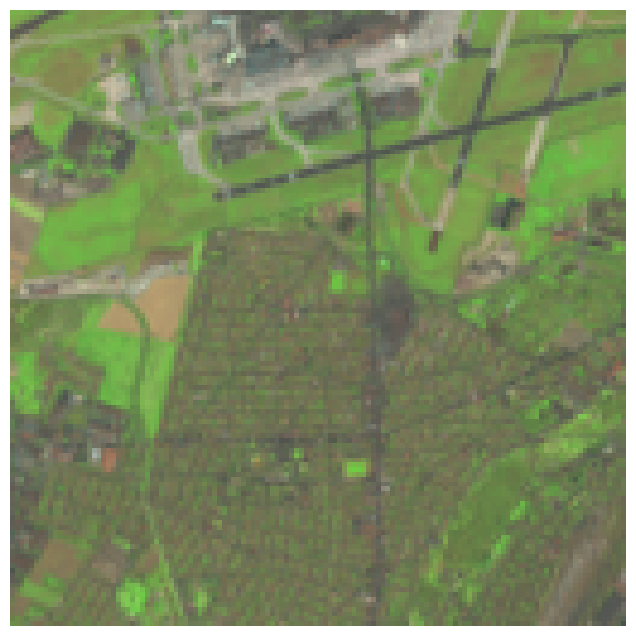

In [49]:
patch_size = 128
rgb_patch = img2021[i_2021:i_2021+patch_size, j_2021:j_2021+patch_size,:]

plt.figure(figsize=(8, 8))
plt.imshow(rgb_patch)
plt.title("")
plt.axis('off')
plt.show()

In [23]:
patch_size = 128

rgb_patch = img2020[i_2020:i_2020+patch_size, j_2020:j_2020+patch_size,:]

plt.figure(figsize=(8, 8))
plt.imshow(rgb_patch)
plt.title("")
plt.axis('off')
plt.show()

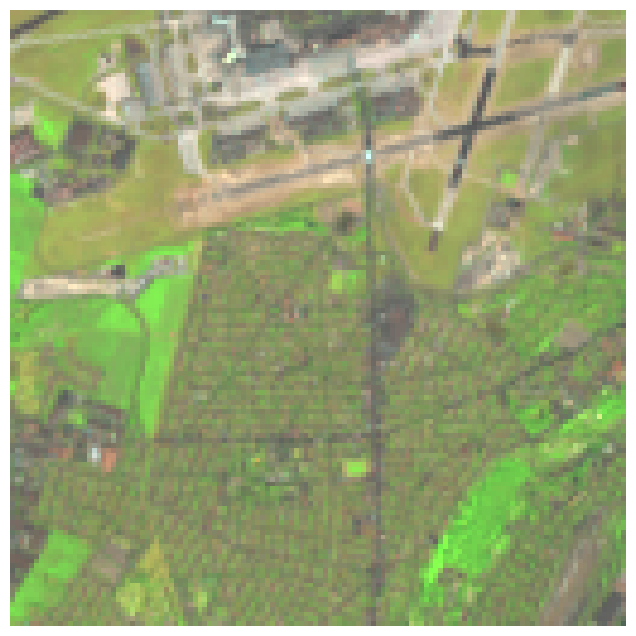

In [24]:
patch_size = 128

rgb_patch = img2019[i_2019:i_2019+patch_size, j_2019:j_2019+patch_size,:]

plt.figure(figsize=(8, 8))
plt.imshow(rgb_patch)
plt.title("")
plt.axis('off')
plt.show()

In [50]:
# code to get patches
import json

def get_geospatial_coordinates(path, num_patch, i_start, j_start, i_length, j_length):
    
    path2021 = os.path.join(path, "2021")
    tif_2021 = return_tif_files(path2021)
    with rasterio.open(tif_2021) as src2021:
        transform2021 = src2021.transform
    
    i_s = np.random.randint(i_start, i_start+i_length, num_patch)
    j_s = np.random.randint(j_start, j_start+j_length, num_patch)

    x_s = [0]* num_patch
    y_s = [0]* num_patch

    for k in range(num_patch):
        i, j = i_s[k], j_s[k]
        x, y = pixel_to_world(j, i, transform2021)
        x_s[k], y_s[k] = x, y

    return x_s , y_s

    
import os
import numpy as np
import rasterio
from pyproj import Transformer

def get_patches(x_s, y_s, path, patch_size):
    num_patches = len(x_s)
    data = {}

    for date in range(2008, 2022):
        if date != 2012:
            print(date)
            new_path = os.path.join(path, str(date))
            path_tif_file = return_tif_files(new_path)
            img = get_array_img(new_path, date)
            imgs_array = np.zeros((num_patches, patch_size, patch_size, 3), dtype=np.uint8)
            space_coordinates = np.zeros((num_patches, patch_size, patch_size, 2), dtype=np.float32)

            with rasterio.open(path_tif_file) as src:
                transform = src.transform
                crs = src.crs

            # prepare coordinate transformer (to lat/lon)
            transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)

            for k in range(num_patches):
                x, y = x_s[k], y_s[k]
                i, j = world_to_pixel(x, y, transform)

                # image patch
                imgs_array[k, :, :, :] = img[i:i+patch_size, j:j+patch_size, :]

                # grid of pixel indices within the patch
                rows = np.arange(i, i + patch_size)
                cols = np.arange(j, j + patch_size)
                cols_grid, rows_grid = np.meshgrid(cols, rows)

                # convert to map coordinates
                xs, ys = rasterio.transform.xy(transform, rows_grid, cols_grid, offset="center")
                xs = np.array(xs).reshape((patch_size, patch_size))
                ys = np.array(ys).reshape((patch_size, patch_size))

                # convert map coords → lon/lat
                lons, lats = transformer.transform(xs, ys)

                # stack and save
                space_coordinates[k, :, :, :] = np.dstack((lats, lons)).astype(np.float32)

            data[str(date)] = {
                "imgs_array": imgs_array,
                "space_coordinates": space_coordinates
            }

    return data

            

        



    

In [ ]:
patch_size_x = 1000
patch_size_y = 600
i = 1800
j = 2600

In [52]:
path = r"C:\Users\adamh\Desktop\Satelite_images\Satellite_Images\Toulouse"
num_patch = 500
i_start, j_start = 1800, 2600
i_length, j_length = 1000, 600
patch_size = 128

x_s, y_s = get_geospatial_coordinates(path, num_patch, i_start, j_start, i_length, j_length)
data = get_patches(x_s, y_s, path, patch_size)


2008


RasterioIOError: : No such file or directory

NameError: name 'imgs_array' is not defined

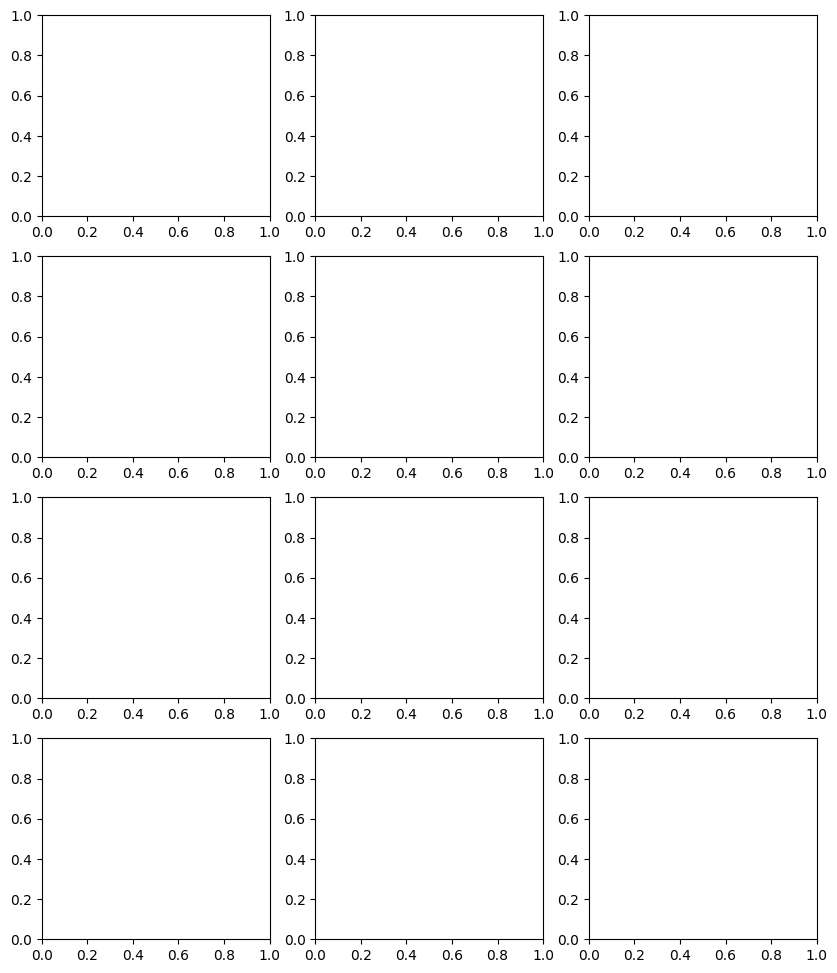

In [10]:
random_indexes = np.random.randint(0, num_patch, 10)

# Set up figure
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 12))
axes = axes.flatten()

# Plot each selected image
for idx, ax in enumerate(axes):
    if idx < len(random_indexes):
        i = random_indexes[idx]
        ax.imshow(imgs_array[i])
        ax.set_title(f"Index: {i}")
    ax.axis('off')

plt.tight_layout()
plt.show()

🎯 Random patch index: 65


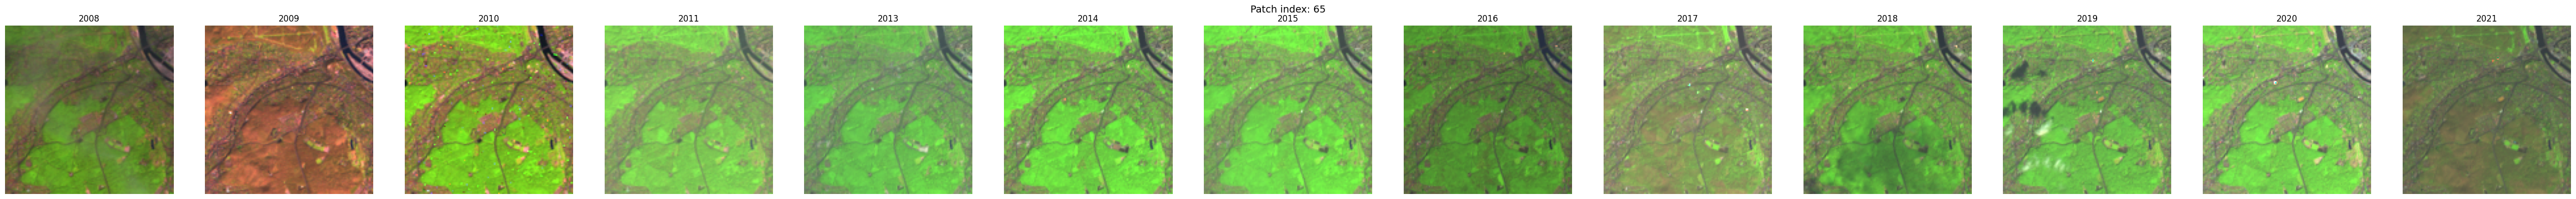

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import random

# pick a random patch index
idx = random.randint(0, num_patch - 1)
print(f"🎯 Random patch index: {idx}")

# get all available years (keys that are digits)
years = sorted([key for key in data.keys() if key.isdigit()])

# prepare figure
n_years = len(years)
plt.figure(figsize=(4 * n_years, 4))

# plot the same patch for each year
for i, year in enumerate(years):
    patch = data[year]["imgs_array"][idx]
    plt.subplot(1, n_years, i + 1)
    plt.imshow(patch)
    plt.title(year)
    plt.axis("off")

plt.suptitle(f"Patch index: {idx}", fontsize=14)
plt.tight_layout()
plt.show()


In [31]:
import pickle
import os

# Path to where you want to save
save_path = r"C:\Users\adamh\Desktop\Satelite_images\patches_data.pkl"

# Save the full data object
with open(save_path, "wb") as f:
    pickle.dump(data, f)

print(f"✅ Data saved successfully at: {save_path}")


✅ Data saved successfully at: C:\Users\adamh\Desktop\Satelite_images\patches_data.pkl


                                  Stop skipping

                                    IRIS correspondance

In [33]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely import wkt
from tqdm import tqdm

def assign_iris_to_data(data, iris_csv_paths, batch_size=100_000):
    """
    Adds 'iris_index' arrays to the existing 'data' dictionary.
    Each iris_index has shape [num_patches, patch_size, patch_size],
    with each pixel containing its CODE_IRIS (string or np.nan).
    """

    for year, content in data.items():
        if not year.isdigit():
            continue
        if int(year) not in iris_csv_paths:
            print(f"⚠️ No IRIS CSV for {year}, skipping...")
            continue

        print(f"\n📅 Processing year {year}...")

        # Load IRIS polygons for that year
        iris_csv = iris_csv_paths[int(year)]
        iris_df = pd.read_csv(iris_csv)
        iris_df["geometry"] = iris_df["geometry"].apply(wkt.loads)
        iris_gdf = gpd.GeoDataFrame(iris_df, geometry="geometry", crs="EPSG:4326")

        # Get pixel coordinate array
        coords = content["space_coordinates"]  # shape [num_patches, H, W, 2]
        num_patches, H, W, _ = coords.shape
        total_points = num_patches * H * W

        print(f"   → Flattening {total_points:,} pixels...")

        # Flatten coordinates
        flat_coords = coords.reshape(-1, 2)
        lats = flat_coords[:, 0]
        lons = flat_coords[:, 1]

        # Prepare output
        codes = np.empty(total_points, dtype=object)

        # Process in batches
        for start in tqdm(range(0, total_points, batch_size), desc=f"Joining {year}", ncols=80):
            end = min(start + batch_size, total_points)
            batch_lats = lats[start:end]
            batch_lons = lons[start:end]

            # Create GeoDataFrame of points
            points_gdf = gpd.GeoDataFrame(
                geometry=gpd.points_from_xy(batch_lons, batch_lats),
                crs="EPSG:4326"
            )

            # Spatial join (vectorized)
            joined = gpd.sjoin(
                points_gdf,
                iris_gdf[["CODE_IRIS", "geometry"]],
                how="left",
                predicate="within"
            )

            codes[start:end] = joined["CODE_IRIS"].to_numpy()

        # Reshape back to [num_patches, H, W]
        iris_index = codes.reshape(num_patches, H, W)

        # Attach to data
        data[year]["iris_index"] = iris_index

        matched = np.count_nonzero(~pd.isna(codes))
        print(f"✅ Finished {year}: matched {matched:,}/{total_points:,} pixels")

    print("\n✅ Added 'iris_index' to all matching years.")
    return data


In [34]:
iris_csv_paths = {
    2011: r"C:\Users\adamh\Desktop\IRIS\2011\iris_latlon.csv",
    2012: r"C:\Users\adamh\Desktop\IRIS\2012\iris_latlon.csv",
    2013: r"C:\Users\adamh\Desktop\IRIS\2013\iris_latlon.csv",
    2014: r"C:\Users\adamh\Desktop\IRIS\2014\iris_latlon.csv",
    2015: r"C:\Users\adamh\Desktop\IRIS\2015\iris_latlon.csv",
    2016: r"C:\Users\adamh\Desktop\IRIS\2016\iris_latlon.csv",
    2017: r"C:\Users\adamh\Desktop\IRIS\2017\iris_latlon.csv",
    2018: r"C:\Users\adamh\Desktop\IRIS\2018\iris_latlon.csv",
    2019: r"C:\Users\adamh\Desktop\IRIS\2019\iris_latlon.csv",
    2020: r"C:\Users\adamh\Desktop\IRIS\2020\iris_latlon.csv",
    2021: r"C:\Users\adamh\Desktop\IRIS\2021\iris_latlon.csv",
}

data = assign_iris_to_data(data, iris_csv_paths)

⚠️ No IRIS CSV for 2008, skipping...
⚠️ No IRIS CSV for 2009, skipping...
⚠️ No IRIS CSV for 2010, skipping...

📅 Processing year 2011...
   → Flattening 8,192,000 pixels...


Joining 2011: 100%|█████████████████████████████| 82/82 [00:09<00:00,  8.30it/s]


✅ Finished 2011: matched 8,192,000/8,192,000 pixels

📅 Processing year 2013...
   → Flattening 8,192,000 pixels...


Joining 2013: 100%|█████████████████████████████| 82/82 [00:10<00:00,  8.17it/s]


✅ Finished 2013: matched 8,192,000/8,192,000 pixels

📅 Processing year 2014...
   → Flattening 8,192,000 pixels...


Joining 2014: 100%|█████████████████████████████| 82/82 [00:10<00:00,  7.77it/s]


✅ Finished 2014: matched 8,192,000/8,192,000 pixels

📅 Processing year 2015...
   → Flattening 8,192,000 pixels...


Joining 2015: 100%|█████████████████████████████| 82/82 [00:10<00:00,  7.63it/s]


✅ Finished 2015: matched 8,192,000/8,192,000 pixels

📅 Processing year 2016...
   → Flattening 8,192,000 pixels...


Joining 2016: 100%|█████████████████████████████| 82/82 [00:10<00:00,  7.65it/s]


✅ Finished 2016: matched 8,192,000/8,192,000 pixels

📅 Processing year 2017...
   → Flattening 8,192,000 pixels...


Joining 2017: 100%|█████████████████████████████| 82/82 [00:11<00:00,  7.33it/s]


✅ Finished 2017: matched 8,192,000/8,192,000 pixels

📅 Processing year 2018...
   → Flattening 8,192,000 pixels...


Joining 2018: 100%|█████████████████████████████| 82/82 [00:11<00:00,  7.29it/s]


✅ Finished 2018: matched 8,192,000/8,192,000 pixels

📅 Processing year 2019...
   → Flattening 8,192,000 pixels...


Joining 2019: 100%|█████████████████████████████| 82/82 [00:11<00:00,  7.32it/s]


✅ Finished 2019: matched 8,192,000/8,192,000 pixels

📅 Processing year 2020...
   → Flattening 8,192,000 pixels...


Joining 2020: 100%|█████████████████████████████| 82/82 [00:11<00:00,  7.41it/s]


✅ Finished 2020: matched 8,192,000/8,192,000 pixels

📅 Processing year 2021...
   → Flattening 8,192,000 pixels...


Joining 2021: 100%|█████████████████████████████| 82/82 [00:10<00:00,  7.56it/s]


✅ Finished 2021: matched 8,192,000/8,192,000 pixels

✅ Added 'iris_index' to all matching years.


In [36]:
from collections import Counter
import numpy as np
import pandas as pd

for year, content in data.items():
    if not year.isdigit():
        continue
    if "iris_index" not in content:
        print(f"⚠️ No iris_index for {year}, skipping...")
        continue

    print(f"\n📊 Computing per-patch IRIS proportions for {year}...")

    iris_index = content["iris_index"]  # shape (num_patches, H, W)
    num_patches = iris_index.shape[0]

    iris_patch_proportions = {}

    for patch_idx in range(num_patches):
        patch = iris_index[patch_idx]

        # Flatten and clean NaNs
        flat = patch.flatten()
        flat = flat[~pd.isna(flat)]

        if len(flat) == 0:
            iris_patch_proportions[patch_idx] = {}
            continue

        # Count frequency of each IRIS code
        counts = Counter(flat)
        total = sum(counts.values())

        # Compute proportions
        proportions = {code: count / total for code, count in counts.items()}

        iris_patch_proportions[patch_idx] = proportions

    # Store in data structure
    data[year]["iris_patch_proportions"] = iris_patch_proportions

    print(f"✅ Added iris_patch_proportions for {year} ({num_patches} patches)")


⚠️ No iris_index for 2008, skipping...
⚠️ No iris_index for 2009, skipping...
⚠️ No iris_index for 2010, skipping...

📊 Computing per-patch IRIS proportions for 2011...
✅ Added iris_patch_proportions for 2011 (500 patches)

📊 Computing per-patch IRIS proportions for 2013...
✅ Added iris_patch_proportions for 2013 (500 patches)

📊 Computing per-patch IRIS proportions for 2014...
✅ Added iris_patch_proportions for 2014 (500 patches)

📊 Computing per-patch IRIS proportions for 2015...
✅ Added iris_patch_proportions for 2015 (500 patches)

📊 Computing per-patch IRIS proportions for 2016...
✅ Added iris_patch_proportions for 2016 (500 patches)

📊 Computing per-patch IRIS proportions for 2017...
✅ Added iris_patch_proportions for 2017 (500 patches)

📊 Computing per-patch IRIS proportions for 2018...
✅ Added iris_patch_proportions for 2018 (500 patches)

📊 Computing per-patch IRIS proportions for 2019...
✅ Added iris_patch_proportions for 2019 (500 patches)

📊 Computing per-patch IRIS proport

In [38]:
import random
import pprint

# --- Choose year ---
year = "2015"

# --- Check that year exists ---
if year not in data:
    print(f"❌ Year {year} not found in data.")
elif "iris_patch_proportions" not in data[year]:
    print(f"⚠️ No 'iris_patch_proportions' found for year {year}. Run the proportion script first.")
else:
    iris_props = data[year]["iris_patch_proportions"]
    num_patches = len(iris_props)

    # --- Pick 5 random patches ---
    random_patches = random.sample(range(num_patches), 5)

    print(f"\n📅 Year: {year}")
    print(f"🎯 Showing 5 random patches out of {num_patches} total:\n")

    for idx in random_patches:
        print(f"🧩 Patch {idx}:")
        pprint.pprint(iris_props[idx])
        print("-" * 60)



📅 Year: 2015
🎯 Showing 5 random patches out of 500 total:

🧩 Patch 23:
{'751166277': 6.103515625e-05,
 '751166377': 0.01275634765625,
 '920090111': 6.103515625e-05,
 '920090112': 0.0137939453125,
 '920250110': 0.00030517578125,
 '920250111': 0.003173828125,
 '920250306': 0.0001220703125,
 '920250401': 0.01715087890625,
 '920260101': 0.00921630859375,
 '920260102': 0.01043701171875,
 '920260103': 0.01910400390625,
 '920260201': 0.0057373046875,
 '920260203': 0.00018310546875,
 '920260402': 0.0076904296875,
 '920260403': 0.0068359375,
 '920260404': 0.0162353515625,
 '920260405': 0.00762939453125,
 '920260406': 0.00909423828125,
 '920260501': 0.00640869140625,
 '920260502': 0.0096435546875,
 '920260503': 0.00860595703125,
 '920260504': 0.00335693359375,
 '920260505': 0.01910400390625,
 '920260506': 0.00543212890625,
 '920260601': 0.00604248046875,
 '920260602': 0.01483154296875,
 '920260603': 0.00885009765625,
 '920260701': 0.00537109375,
 '920260702': 0.0037841796875,
 '920260703': 0.00

                                     Socioeconomical vector

In [34]:
import os
import pandas as pd
import re

base_path = r"C:\Users\adamh\Desktop\IRIS"

# pattern of expected IRIS variable prefixes per year
expected_prefixes = [f"P{y%100:02d}_" for y in range(2013, 2022)] + [f"C{y%100:02d}_" for y in range(2013, 2022)]

results = {}

for year in range(2013, 2022):
    year_path = os.path.join(base_path, str(year))
    if not os.path.exists(year_path):
        print(f"⚠️ Missing folder: {year_path}")
        continue

    # find Population file
    pop_file = None
    for f in os.listdir(year_path):
        if f.lower().startswith("population"):
            pop_file = os.path.join(year_path, f)
            break

    if not pop_file:
        print(f"❌ No Population file found for {year}")
        continue

    # try reading file
    ext = os.path.splitext(pop_file)[1].lower()

    try:
        if ext in [".xls", ".xlsx"]:
            df = pd.read_excel(pop_file, header=None)
        else:
            # detect delimiter for CSV
            with open(pop_file, "r", encoding="utf-8") as f:
                first_line = f.readline()
                sep = ";" if ";" in first_line and "," not in first_line else ","
            df = pd.read_csv(pop_file, nrows=5, sep=sep, header=None)
    except Exception as e:
        print(f"⚠️ Error reading {year}: {e}")
        continue

    # Flatten potential headers and data to strings for scanning
    text_data = " ".join(df.astype(str).values.flatten())

    # find all column-like tokens (P13_POPxxx etc.)
    found_vars = set(re.findall(r"[PC]\d{2}_[A-Z0-9]+", text_data))

    results[year] = sorted(found_vars)
    print(f"📅 {year}: found {len(found_vars)} IRIS variable codes")

# --- summary check across years ---
print("\n================ SUMMARY OF VARIABLES ================")
common_vars = set.intersection(*[set(v) for v in results.values() if v])
all_vars = set.union(*[set(v) for v in results.values() if v])

print(f"✅ Common variables across all years: {len(common_vars)}")
print(f"🧩 Total distinct variables across all years: {len(all_vars)}")

for y in sorted(results.keys()):
    extras = set(results[y]) - common_vars
    print(f"• {y}: {len(results[y])} vars, {len(extras)} unique to this year")


📅 2013: found 45 IRIS variable codes
📅 2014: found 45 IRIS variable codes
📅 2015: found 45 IRIS variable codes
📅 2016: found 45 IRIS variable codes
📅 2017: found 45 IRIS variable codes
📅 2018: found 45 IRIS variable codes
📅 2019: found 45 IRIS variable codes
📅 2020: found 45 IRIS variable codes
📅 2021: found 45 IRIS variable codes

================ SUMMARY OF VARIABLES ================
✅ Common variables across all years: 0
🧩 Total distinct variables across all years: 405
• 2013: 45 vars, 45 unique to this year
• 2014: 45 vars, 45 unique to this year
• 2015: 45 vars, 45 unique to this year
• 2016: 45 vars, 45 unique to this year
• 2017: 45 vars, 45 unique to this year
• 2018: 45 vars, 45 unique to this year
• 2019: 45 vars, 45 unique to this year
• 2020: 45 vars, 45 unique to this year
• 2021: 45 vars, 45 unique to this year


In [46]:
import importlib
import dummy_variables

importlib.reload(dummy_variables)
print(dir(dummy_variables))


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'iris_variables_2013', 'iris_variables_2014', 'iris_variables_2015', 'iris_variables_2016', 'iris_variables_2017', 'iris_variables_2018', 'iris_variables_2019', 'iris_variables_2020', 'iris_variables_2021']


In [49]:
from dummy_variables import *

# All your yearly dictionaries
year_dicts = {
    2013: iris_variables_2013,
    2014: iris_variables_2014,
    2015: iris_variables_2015,
    2016: iris_variables_2016,
    2017: iris_variables_2017,
    2018: iris_variables_2018,
    2019: iris_variables_2019,
    2020: iris_variables_2020,
    2021: iris_variables_2021,
}

def flatten_keys(d):
    keys = []
    for k, v in d.items():
        if isinstance(v, dict):
            keys.extend(flatten_keys(v))
        else:
            keys.append(k)
    return keys

# Extract and normalize variable names (remove year prefix)
normalized = {
    year: {k[4:] if k[0] in ['P','C'] and k[2].isdigit() else k for k in flatten_keys(d)}
    for year, d in year_dicts.items()
}

# Find if all normalized variable sets are identical
first_set = list(normalized.values())[0]
identical = all(v == first_set for v in normalized.values())

print("✅ Same variable structure across years:", identical)
print(f"📊 Number of variables per year: {[len(v) for v in normalized.values()]}")


✅ Same variable structure across years: False
📊 Number of variables per year: [85, 84, 84, 84, 84, 84, 84, 83, 83]


In [ ]:
import pandas as pd
import os
import numpy as np
from dummy_variables import *


def load_population_file(path):
    """Reads a population file (csv/xls/xlsx) with flexible encoding handling."""
    ext = os.path.splitext(path)[1].lower()

    if ext == ".csv":
        # Try UTF-8 first, then Latin-1 fallback
        try:
            return pd.read_csv(path, encoding="utf-8")
        except UnicodeDecodeError:
            return pd.read_csv(path, encoding="latin1")

    elif ext in (".xls", ".xlsx"):
        # Excel files don't need encoding; let pandas handle it
        return pd.read_excel(path)

    else:
        raise ValueError(f"Unsupported file type: {ext}")



# === CONFIG ===
root_dir = r"C:\Users\adamh\Desktop\IRIS"
years = list(range(2013, 2022))
# ==============

# --- Load all IRIS dictionaries ---
year_dicts = {
    2013: iris_variables_2013,
    2014: iris_variables_2014,
    2015: iris_variables_2015,
    2016: iris_variables_2016,
    2017: iris_variables_2017,
    2018: iris_variables_2018,
    2019: iris_variables_2019,
    2020: iris_variables_2020,
    2021: iris_variables_2021,
}

# --- STEP 1: Find common population variable descriptions ---
def flatten(d):
    out = {}
    for k, v in d.items():
        if isinstance(v, dict):
            out.update(flatten(v))
        else:
            out[k] = v
    return out

flattened = {y: flatten(d) for y, d in year_dicts.items()}

# keep only population keys like "P19_POP", etc.
population_only = {
    y: {k: v for k, v in flat.items() if k.startswith(f"P{str(y)[-2:]}")}
    for y, flat in flattened.items()
}

# find common textual variable descriptions
common_desc = set.intersection(*[set(v.values()) for v in population_only.values()])
desc_to_var = {y: {v: k for k, v in flat.items() if v in common_desc} for y, flat in population_only.items()}
common_desc = sorted(list(common_desc))

print(f"✅ Found {len(common_desc)} common population variables across all years.")

# --- STEP 2: For each year, compute weighted socioeconomic vectors and store in data ---
for year in years:
    print(f"\nProcessing {year}...")
    year_dir = os.path.join(root_dir, str(year))

    # find the population file (handle both 'Population' and 'Population.csv')
    pop_file = [f for f in os.listdir(year_dir) if "Population" in f][0]
    pop_path = os.path.join(year_dir, pop_file)

    pop_df = load_population_file(pop_path)

    iris_col = next((c for c in pop_df.columns if "IRIS" in c), None)
    if iris_col is None:
        raise ValueError(f"No IRIS column found in {pop_file}")

    pop_df.set_index(iris_col, inplace=True)

    pop_vars = list(desc_to_var[year].values())
    pop_df = pop_df[pop_vars]

    for patch_idx, patch_info in data[str(year)].items():
        proportions = patch_info["iris_proportions"]
        vector = []

        for desc in common_desc:
            var = desc_to_var[year][desc]
            weighted_sum, total_weight = 0.0, 0.0

            for iris, prop in proportions.items():
                if iris in pop_df.index:
                    val = pop_df.loc[iris, var]
                    if pd.notna(val):
                        weighted_sum += val * prop
                        total_weight += prop

            avg_val = weighted_sum / total_weight if total_weight > 0 else np.nan
            vector.append(avg_val)

        # Store vector as numpy array directly in the data structure
        data[str(year)][patch_idx]["socioeconomic_vector"] = np.array(vector, dtype=float)

print("\n✅ All socioeconomic vectors computed and stored in data!")

# optional summary
for year in years:
    first_patch = next(iter(data[str(year)]))
    vec = data[str(year)][first_patch]["socioeconomic_vector"]
    print(f"{year}: vector length = {len(vec)}")



✅ Found 45 common population variables across all years.

Processing 2013...


ValueError: No IRIS column found in Population.xls

In [58]:
import pandas as pd
import numpy as np
import os
from dummy_variables import *

# === CONFIG ===
root_dir = r"C:\Users\adamh\Desktop\IRIS"
years = list(range(2013, 2022))
# ==============

# --- Load all IRIS variable dictionaries ---
year_dicts = {
    2013: iris_variables_2013,
    2014: iris_variables_2014,
    2015: iris_variables_2015,
    2016: iris_variables_2016,
    2017: iris_variables_2017,
    2018: iris_variables_2018,
    2019: iris_variables_2019,
    2020: iris_variables_2020,
    2021: iris_variables_2021,
}

# --- Helper: Flatten nested dictionaries ---
def flatten(d):
    out = {}
    for k, v in d.items():
        if isinstance(v, dict):
            out.update(flatten(v))
        else:
            out[k] = v
    return out

# --- STEP 1: find population-related variables ---
flattened = {y: flatten(d) for y, d in year_dicts.items()}

population_only = {
    y: {k: v for k, v in flat.items() if "POP" in k}
    for y, flat in flattened.items()
}

common_desc = set.intersection(*[set(v.values()) for v in population_only.values()])
desc_to_var = {y: {v: k for k, v in flat.items() if v in common_desc} for y, flat in population_only.items()}
common_desc = sorted(list(common_desc))

print(f"✅ Found {len(common_desc)} common population variables across all years.")

# --- STEP 2: Robust population file loader ---
def load_population_file(path, year):
    ext = os.path.splitext(path)[1].lower()

    if ext in [".xls", ".xlsx"]:
        # Older Excel structure → skip metadata
        return pd.read_excel(path, header=5)
    elif ext == ".csv":
        # Newer CSV with semicolon separator
        try:
            return pd.read_csv(path, sep=";", encoding="utf-8")
        except UnicodeDecodeError:
            return pd.read_csv(path, sep=";", encoding="latin1")
    else:
        raise ValueError(f"Unsupported file type: {ext}")

# --- STEP 3: compute and store socioeconomic vectors ---
for year in years:
    print(f"\n📊 Processing {year}...")
    year_dir = os.path.join(root_dir, str(year))
    pop_file = [f for f in os.listdir(year_dir) if "Population" in f][0]
    pop_path = os.path.join(year_dir, pop_file)

    # Load data properly
    pop_df = load_population_file(pop_path, year)

    # Detect IRIS column automatically
    iris_col = next((c for c in pop_df.columns if "IRIS" in str(c)), None)
    if iris_col is None:
        raise ValueError(f"No IRIS column found in {pop_file}")

    pop_df.set_index(iris_col, inplace=True)

    # Keep only variables that correspond to the common population descriptors
    pop_vars = list(desc_to_var[year].values())
    available = [v for v in pop_vars if v in pop_df.columns]
    pop_df = pop_df[available].apply(pd.to_numeric, errors="coerce")

    # Compute weighted averages per patch
    for patch_idx, patch_info in data[str(year)].items():
        proportions = patch_info["iris_proportions"]
        vector = []

        for desc in common_desc:
            var = desc_to_var[year][desc]
            if var not in pop_df.columns:
                vector.append(np.nan)
                continue

            weighted_sum, total_weight = 0.0, 0.0
            for iris, prop in proportions.items():
                if iris in pop_df.index:
                    val = pop_df.loc[iris, var]
                    if pd.notna(val):
                        weighted_sum += val * prop
                        total_weight += prop

            avg_val = weighted_sum / total_weight if total_weight > 0 else np.nan
            vector.append(avg_val)

        # Store as numpy array
        data[str(year)][patch_idx]["socioeconomic_vector"] = np.array(vector, dtype=float)

print("\n✅ All socioeconomic vectors computed and stored in data!")

# --- Optional quick summary ---
for year in years:
    first_patch = next(iter(data[str(year)]))
    vec = data[str(year)][first_patch]["socioeconomic_vector"]
    print(f"{year}: vector length = {len(vec)}")


✅ Found 26 common population variables across all years.

📊 Processing 2013...


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [41]:
show(data)
save(data, save_path)

🔎 Exploring data structure
------------------------------------------------------------
2008
  ├─ imgs_array                → array shape=(500, 128, 128, 3), dtype=uint8
  ├─ space_coordinates         → array shape=(500, 128, 128, 2), dtype=float32
------------------------------------------------------------
2009
  ├─ imgs_array                → array shape=(500, 128, 128, 3), dtype=uint8
  ├─ space_coordinates         → array shape=(500, 128, 128, 2), dtype=float32
------------------------------------------------------------
2010
  ├─ imgs_array                → array shape=(500, 128, 128, 3), dtype=uint8
  ├─ space_coordinates         → array shape=(500, 128, 128, 2), dtype=float32
------------------------------------------------------------
2011
  ├─ imgs_array                → array shape=(500, 128, 128, 3), dtype=uint8
  ├─ space_coordinates         → array shape=(500, 128, 128, 2), dtype=float32
  ├─ iris_index                → array shape=(500, 128, 128), dtype=object
  ├─ iris_